In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from primeGraph.models import GraphState
from primeGraph.buffer import History
from primeGraph import Graph, START, END
from rich import print as rprint
from primeGraph.graph.engine import GraphExecutor
import time

import logging

logging.basicConfig(
    level=logging.DEBUG,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)

class StateForTestWithHistory(GraphState):
    execution_order: History[str]


def test_graph():
    state = StateForTestWithHistory(execution_order=[])
    graph = Graph(state=state)

    @graph.node()
    def task1(state):
        time.sleep(1)
        print("task1")
        return {"execution_order": "task1"}

    @graph.node(interrupt="after")
    def task2(state):
        time.sleep(2)
        print("task2")
        return {"execution_order": "task2"}

    @graph.node()
    def task3(state):
        time.sleep(2)
        print("task3")
        return {"execution_order": "task3"}

    @graph.node()
    def task4(state):
        time.sleep(1)
        print("task4")
        return {"execution_order": "task4"}
    
    @graph.node()
    def task5(state):
        time.sleep(1)
        print("task5")
        return {"execution_order": "task5"}
    
    @graph.node()
    def task6(state):
        time.sleep(1)
        print("task6")
        return {"execution_order": "task6"}

    # Create parallel paths
    graph.add_edge(START, "task1")
    graph.add_edge("task1", "task2")
    graph.add_edge("task1", "task3")
    graph.add_edge("task2", "task4")
    graph.add_edge("task3", "task5")
    graph.add_edge("task4", "task6")
    graph.add_edge("task5", "task6")
    graph.add_edge("task6", END)

    graph.compile()

    return graph


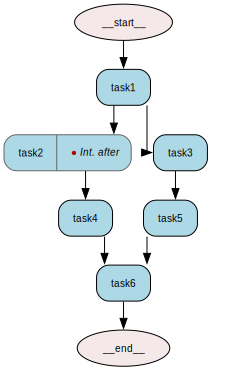

In [4]:
graph = test_graph()
graph.visualize()

In [5]:
import asyncio
# In your notebook
executor = GraphExecutor(graph)
task = asyncio.create_task(executor.execute())  # Start execution

# Wait a bit for it to hit the interrupt
await asyncio.sleep(10)  

# Then call resume to continue
# executor.resume()

DEBUG:primeGraph.graph.engine:Executing node '__start__' with state: version='a68afb7bed1b464bc9ee75fa7adf0b26' execution_order=[]
DEBUG:primeGraph.graph.engine:Executing node 'task1' with state: version='a68afb7bed1b464bc9ee75fa7adf0b26' execution_order=[]
DEBUG:primeGraph.graph.engine:Node 'task1' launches parallel branches: ['task2', 'task3']
DEBUG:primeGraph.graph.engine:Executing node 'task2' with state: version='a68afb7bed1b464bc9ee75fa7adf0b26' execution_order=[]
DEBUG:primeGraph.graph.engine:Executing node 'task3' with state: version='a68afb7bed1b464bc9ee75fa7adf0b26' execution_order=[]


task1


DEBUG:primeGraph.graph.engine:[Interrupt-after] Executed node 'task2'.
DEBUG:primeGraph.graph.engine:Execution paused. Waiting for resume...
DEBUG:primeGraph.graph.engine:Executing node 'task5' with state: version='a68afb7bed1b464bc9ee75fa7adf0b26' execution_order=[]


task2
task3


DEBUG:primeGraph.graph.engine:Executing node 'task6' with state: version='a68afb7bed1b464bc9ee75fa7adf0b26' execution_order=[]


task5
task6


DEBUG:primeGraph.graph.engine:Execution resumed.
DEBUG:primeGraph.graph.engine:Executing node 'task4' with state: version='a68afb7bed1b464bc9ee75fa7adf0b26' execution_order=[]
DEBUG:primeGraph.graph.engine:Executing node 'task6' with state: version='a68afb7bed1b464bc9ee75fa7adf0b26' execution_order=[]


task4
task6


In [6]:
executor.resume()